# Model 3: Stacked features: MFCC, STFT, Spectral Centroid, etc.

## Extracting the data

In [1]:
import os

ravdess_directory_list = os.listdir("dataset")

file_emotion = []
file_path = []
for i in ravdess_directory_list:
    actor = os.listdir("dataset/" + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append("dataset/" + i + '/' + f)


## We use multiple audio features such as MFCCs, STFT, Spectral Centroid, etc. to make a 3-channel image to feed into the CNN

Example:

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# function for padding an image to target dimensions

def padding(array, x, y):
    h = array.shape[0]
    w = array.shape[1]
    a = max((x - h) // 2,0)
    aa = max(0,x - a - h)
    b = max(0,(y - w) // 2)
    bb = max(y - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [4]:
# function to normalise an array
def normalize(array):
    return (array - array.mean()) / (array.std())

In [5]:
# function which computes the various audio features and stacks them to form an image

def make_feature_image(file_path):
    max_size = 216

    # loading the audio file
    data, sampling_rate = librosa.load(file_path, duration = 5)

    # STFT
    stft = padding(np.abs(librosa.stft(y=data, n_fft = 255, hop_length = 512)), 128, max_size)

    # MFCC
    mfcc = padding(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=128), 128, max_size)

    # spectral centroid
    cent = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)

    # chroma-STFT
    chroma = librosa.feature.chroma_stft(y=data, sr=sampling_rate)

    # spectral bandwidth
    band = librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate)

    image_base = np.array([padding(normalize(band), 1, max_size)]).reshape(1, max_size)
    image_base = np.append(image_base, padding(normalize(cent), 1, max_size), axis=0)

    # repeat padded spectral centroid, bandwidth and chroma 12 times to match the dimensions of the STFT and MFCC
    for i in range(12):
        image = np.append(image_base,padding(normalize(band),1, max_size), axis=0)
        image = np.append(image, padding(normalize(cent),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma),12, max_size), axis=0)
    
    image = np.dstack((image, np.abs(stft)))
    image = np.dstack((image, mfcc))

    return image

In [6]:
# function which computes the various audio features and stacks them to form an image

def make_feature_image(file_name):
    max_size=216 

    # loading the audio file
    data, sampling_rate = librosa.load(file_name, duration=5)

    # STFT
    stft = padding(np.abs(librosa.stft(y=data, n_fft=255, hop_length = 512)), 128, max_size)

    # MFCC
    mfcc = padding(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=128),128,max_size)

    # spectral centroid
    cent = librosa.feature.spectral_centroid(y=data, sr=sampling_rate)

    # chroma-STFT
    chroma = librosa.feature.chroma_stft(y=data, sr=sampling_rate)

    # spectral bandwidth
    band = librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate)

    image = np.array([padding(normalize(band),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(cent),1, max_size), axis=0) 

    # repeat padded spectral centroid, bandwidth and chroma 12 times to match the dimensions of the STFT and MFCC
    for i in range(9):
        image = np.append(image,padding(normalize(band),1, max_size), axis=0)
        image = np.append(image, padding(normalize(cent),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma),12, max_size), axis=0)

    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,mfcc))
    
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


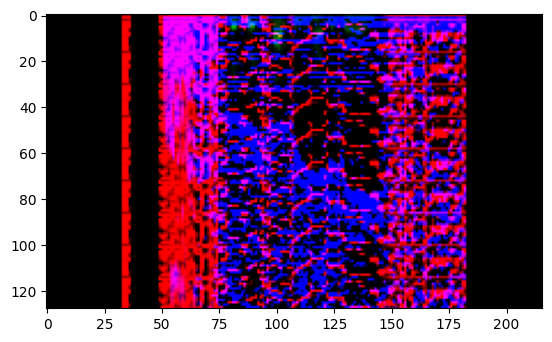

In [7]:
# example
image = make_feature_image("dataset/Actor_07/03-01-02-01-01-01-07.wav")
plt.imshow(image)

In [8]:
import glob

In [9]:
stacked_spectrogram_dataset = []

for file in glob.glob("dataset/Actor_*/*.wav"):
    stacked_spectrogram_dataset.append(make_feature_image(file))

In [10]:
stacked_spectrogram_dataset = np.array(stacked_spectrogram_dataset)
stacked_spectrogram_dataset.shape

(1440, 128, 216, 3)

1440 3-channel images

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [12]:
X = torch.tensor(stacked_spectrogram_dataset, dtype=torch.float32)
y = torch.tensor([i-1 for i in file_emotion], dtype=torch.int64)

In [13]:
# reshaping X to a tensor of shape (batch_size, channels, height, width)
X = X.permute(0, 3, 1, 2) 

In [20]:
# train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# using gpu if available    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# building the model

class CNN(nn.Module):
    def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                
                nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                
                nn.Flatten(),
                nn.Linear(55296,1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 8)
            )
        
    def forward(self, x):
        return self.network(x)
    
model = CNN()
model = model.to(device)
print(model)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=55296, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=8, bias=True)
  )
)


In [27]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

In [28]:
# training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 40
batch_size = 32

train_data = TensorDataset(X_train, y_train)
train_loader = create_data_loader(train_data, batch_size)

In [29]:
from tqdm import tqdm

for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Epoch [{e+1}] Training loss: {running_loss/len(train_loader)}")

100%|██████████| 22/22 [00:02<00:00, 10.48it/s]


Epoch [1] Training loss: 3.882309366356243


100%|██████████| 22/22 [00:02<00:00, 10.99it/s]


Epoch [2] Training loss: 1.9697094017809087


100%|██████████| 22/22 [00:02<00:00, 10.96it/s]


Epoch [3] Training loss: 1.9355733340436763


100%|██████████| 22/22 [00:02<00:00, 10.89it/s]


Epoch [4] Training loss: 1.922641640359705


100%|██████████| 22/22 [00:02<00:00, 10.97it/s]


Epoch [5] Training loss: 1.8492162769491023


100%|██████████| 22/22 [00:02<00:00, 10.93it/s]


Epoch [6] Training loss: 1.5791637897491455


100%|██████████| 22/22 [00:02<00:00, 10.89it/s]


Epoch [7] Training loss: 1.3556570302356372


100%|██████████| 22/22 [00:02<00:00, 10.82it/s]


Epoch [8] Training loss: 1.1448672738942234


100%|██████████| 22/22 [00:02<00:00, 10.76it/s]


Epoch [9] Training loss: 0.9442192072218115


100%|██████████| 22/22 [00:02<00:00, 10.88it/s]


Epoch [10] Training loss: 0.7305383858355609


100%|██████████| 22/22 [00:02<00:00, 10.82it/s]


Epoch [11] Training loss: 0.5171954445540905


100%|██████████| 22/22 [00:02<00:00, 10.79it/s]


Epoch [12] Training loss: 0.48027608543634415


100%|██████████| 22/22 [00:02<00:00, 10.80it/s]


Epoch [13] Training loss: 0.4190033667466857


100%|██████████| 22/22 [00:02<00:00, 10.87it/s]


Epoch [14] Training loss: 0.3031602039594542


100%|██████████| 22/22 [00:02<00:00, 10.84it/s]


Epoch [15] Training loss: 0.31887959968298674


100%|██████████| 22/22 [00:02<00:00, 10.82it/s]


Epoch [16] Training loss: 0.2884894548491998


100%|██████████| 22/22 [00:02<00:00, 10.76it/s]


Epoch [17] Training loss: 0.16506382924589244


100%|██████████| 22/22 [00:02<00:00, 10.81it/s]


Epoch [18] Training loss: 0.18310658565976404


100%|██████████| 22/22 [00:02<00:00, 10.85it/s]


Epoch [19] Training loss: 0.052174312475306746


100%|██████████| 22/22 [00:02<00:00, 10.86it/s]


Epoch [20] Training loss: 0.03000574574848129


100%|██████████| 22/22 [00:02<00:00, 10.86it/s]


Epoch [21] Training loss: 0.03210141394414346


100%|██████████| 22/22 [00:02<00:00, 10.82it/s]


Epoch [22] Training loss: 0.02235271062024615


100%|██████████| 22/22 [00:02<00:00, 10.83it/s]


Epoch [23] Training loss: 0.01771792662541636


100%|██████████| 22/22 [00:02<00:00, 10.85it/s]


Epoch [24] Training loss: 0.014999575483670924


100%|██████████| 22/22 [00:02<00:00, 10.82it/s]


Epoch [25] Training loss: 0.012997490701805376


100%|██████████| 22/22 [00:02<00:00, 10.85it/s]


Epoch [26] Training loss: 0.004883867410006298


100%|██████████| 22/22 [00:02<00:00, 10.83it/s]


Epoch [27] Training loss: 0.0017606929436210935


100%|██████████| 22/22 [00:02<00:00, 10.78it/s]


Epoch [28] Training loss: 0.000593175653028249


100%|██████████| 22/22 [00:02<00:00, 10.81it/s]


Epoch [29] Training loss: 0.00044880627212313067


100%|██████████| 22/22 [00:02<00:00, 10.81it/s]


Epoch [30] Training loss: 0.00036582065558832255


100%|██████████| 22/22 [00:02<00:00, 10.83it/s]


Epoch [31] Training loss: 0.00031246313673446736


100%|██████████| 22/22 [00:02<00:00, 10.80it/s]


Epoch [32] Training loss: 0.0002719694039114984


100%|██████████| 22/22 [00:02<00:00, 10.84it/s]


Epoch [33] Training loss: 0.0002401261474253922


100%|██████████| 22/22 [00:02<00:00, 10.83it/s]


Epoch [34] Training loss: 0.0002134214184727832


100%|██████████| 22/22 [00:02<00:00, 10.86it/s]


Epoch [35] Training loss: 0.0001908256262223321


100%|██████████| 22/22 [00:02<00:00, 10.84it/s]


Epoch [36] Training loss: 0.00017186159363353164


100%|██████████| 22/22 [00:02<00:00, 10.79it/s]


Epoch [37] Training loss: 0.00015562941278155697


100%|██████████| 22/22 [00:02<00:00, 10.81it/s]


Epoch [38] Training loss: 0.00014185981023150487


100%|██████████| 22/22 [00:02<00:00, 10.83it/s]


Epoch [39] Training loss: 0.00012956882435653162


100%|██████████| 22/22 [00:02<00:00, 10.74it/s]

Epoch [40] Training loss: 0.00011891693452525942


In [31]:
test_data = TensorDataset(X_test, y_test)
test_loader = create_data_loader(test_data, batch_size)

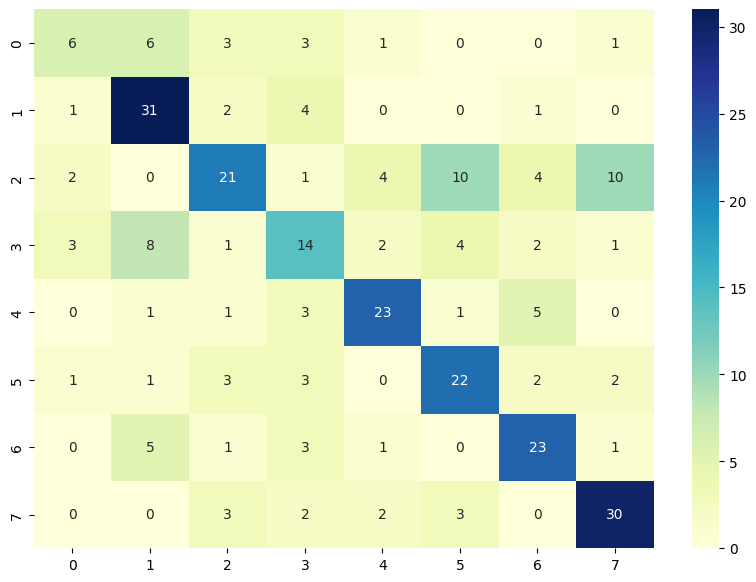

In [32]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(8)], columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.30      0.36        20
           1       0.60      0.79      0.68        39
           2       0.60      0.40      0.48        52
           3       0.42      0.40      0.41        35
           4       0.70      0.68      0.69        34
           5       0.55      0.65      0.59        34
           6       0.62      0.68      0.65        34
           7       0.67      0.75      0.71        40

    accuracy                           0.59       288
   macro avg       0.58      0.58      0.57       288
weighted avg       0.59      0.59      0.58       288



## We achieve an accuracy of 60% from training a 2D CNN on various stacked features of the audio.